In [1]:
import pandas as pd
import os
from glob import glob
import re
path = r"C:\Users\sachi\Documents\Researchcode\master_combined_risk"
csv_files = glob(os.path.join(path, "*.csv"))
combined_dfs = []
for file in csv_files:
    filename = os.path.basename(file).replace(".csv", "")
    lag_match = re.search(r'_(\d+)_', filename)
    Type = filename.strip().split('_')[-1]
    lag = int(lag_match.group(1)) if lag_match else None    
    df = pd.read_csv(file)
    df['lag'] = lag
    df['Type'] = Type
    combined_dfs.append(df)
df = pd.concat(combined_dfs, ignore_index=True)
df.rename(columns = {'Unnamed: 0':'Ticker'}, inplace = True)
def filter_df(lag,ticker,df):
    df = df[df['lag'] == lag]
    df = df[df['Ticker'] == str(ticker)]

    return df
data = filter_df(5,'SPY',df)


In [6]:
data = data[['Ticker','Model', 'Accuracy_x', 'Confusion Matrix_x','Return [%]_x','Buy & Hold Return [%]_x','Return [%]_y', 'Type']]
data.reset_index(inplace = True,drop = True)
data.loc[12,'Accuracy_x'] = 1
data.loc[25,'Accuracy_x'] = 1
data.loc[38,'Accuracy_x'] = 1
data.loc[12,'Confusion Matrix_x'] = 1
data.loc[25,'Confusion Matrix_x'] = 1
data.loc[38,'Confusion Matrix_x'] = 1


def get_metrics(data):
    def extract_matrix_values(matrix_str):
        matrix_str = str(matrix_str)
        numbers = re.findall(r'\d+', matrix_str)
        if len(numbers) < 4:
            return pd.Series({'TN': 1, 'FP': 1, 'FN': 1, 'TP': 1})
        
        numbers = [int(x) for x in numbers]
        
        return pd.Series({
            'TN': numbers[0],
            'FP': numbers[1],
            'FN': numbers[2],
            'TP': numbers[3]
        })
    new_columns = data['Confusion Matrix_x'].apply(extract_matrix_values)
    data[['TN', 'FP', 'FN', 'TP']] = new_columns
    
    def calculate_metrics(row):
        tp = row.get('TP', 0)
        fp = row.get('FP', 0)
        fn = row.get('FN', 0)
        tn = row.get('TN', 0)

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

        return pd.Series({
            'Precision': precision,
            'TPR': tpr,         
            'FPR': fpr
        })

    
    metrics = data.apply(calculate_metrics, axis=1)
    data = pd.concat([data, metrics], axis=1)
    data.drop(columns = ['Confusion Matrix_x'],inplace = True)
    return data

data = get_metrics(data)

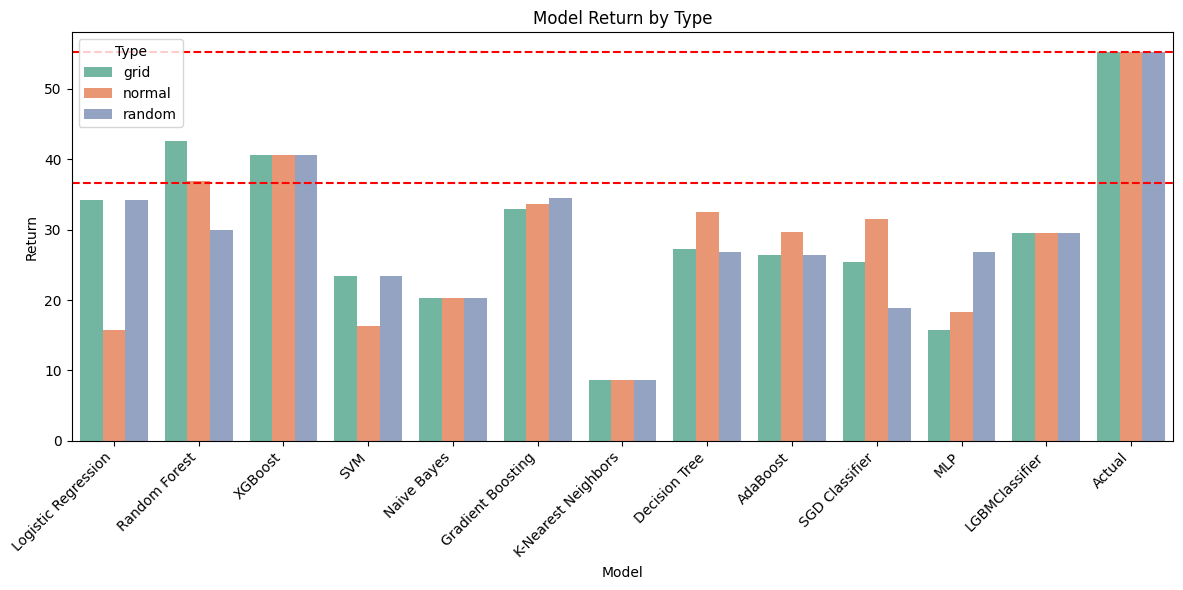

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting using seaborn barplot
plt.figure(figsize=(12, 6))

# Create a barplot for Accuracy, grouped by Type and showing each Model
sns.barplot(data=data, x="Model", y="Return [%]_x", hue="Type", palette="Set2")

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.axhline(y=data['Buy & Hold Return [%]_x'].mean(), color='r', linestyle='--', label='Buy & Hold Return [%]')
plt.axhline(y=data['Return [%]_x'].loc[12], color='r', linestyle='--', label='Actual')
# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Return')
plt.title('Model Return by Type')

# Show the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of Metrics')

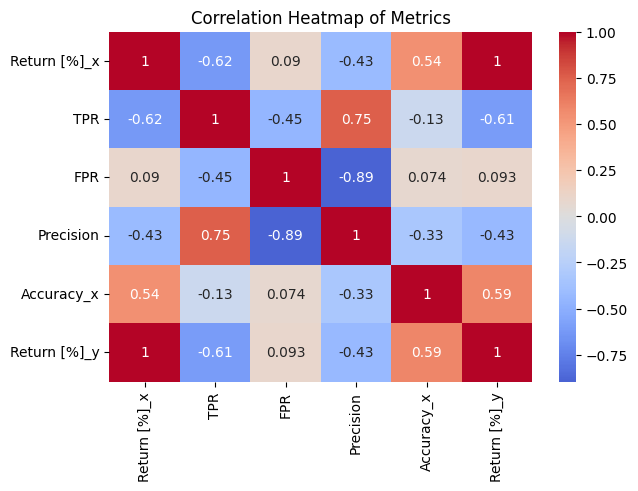

In [ ]:
# Calculate correlations
metrics = ['Return [%]_x', 'TPR', 'FPR', 'Precision', 'Accuracy_x','Return [%]_y']
correlation_matrix = data[metrics].corr()

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Correlation Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Metrics')




Text(0.5, 1.0, 'Covariance Heatmap of Metrics')

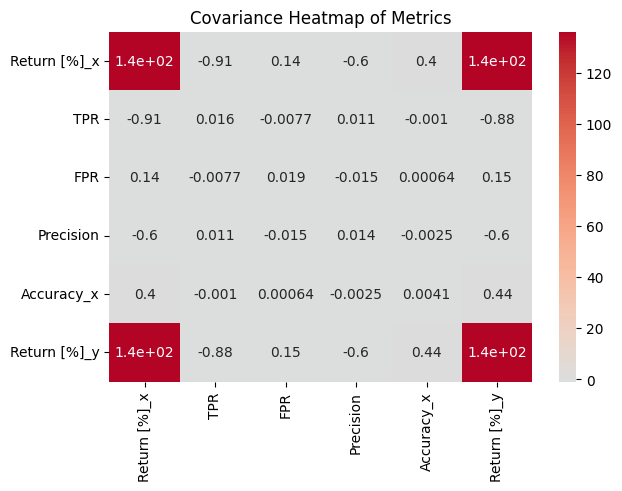

In [ ]:
# Calculate correlations
metrics = ['Return [%]_x', 'TPR', 'FPR', 'Precision', 'Accuracy_x','Return [%]_y']
correlation_matrix = data[metrics].cov()

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Correlation Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Covariance Heatmap of Metrics')




Text(0, 0.5, 'Return %')

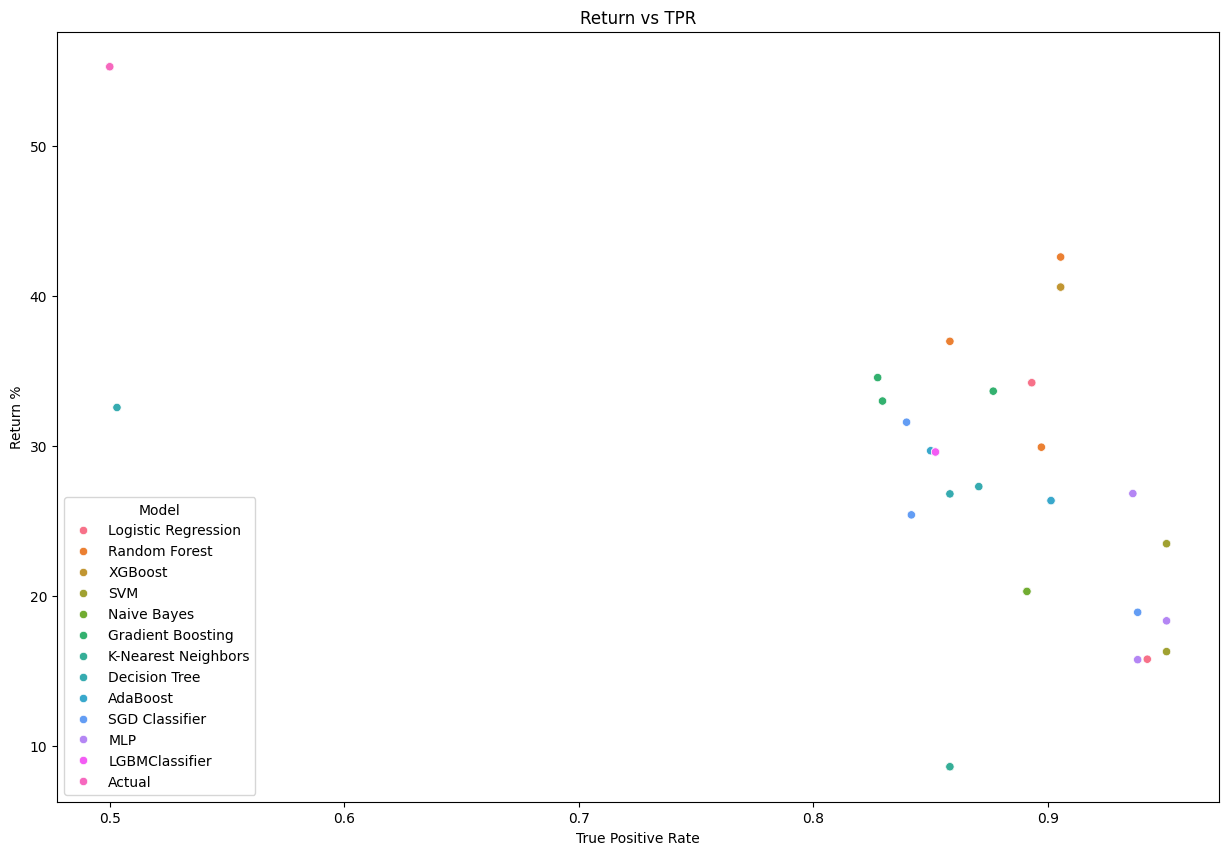

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='TPR', y='Return [%]_x',hue = 'Model')
plt.title('Return vs TPR')
plt.xlabel('True Positive Rate')
plt.ylabel('Return %')

Text(0, 0.5, 'Return %')

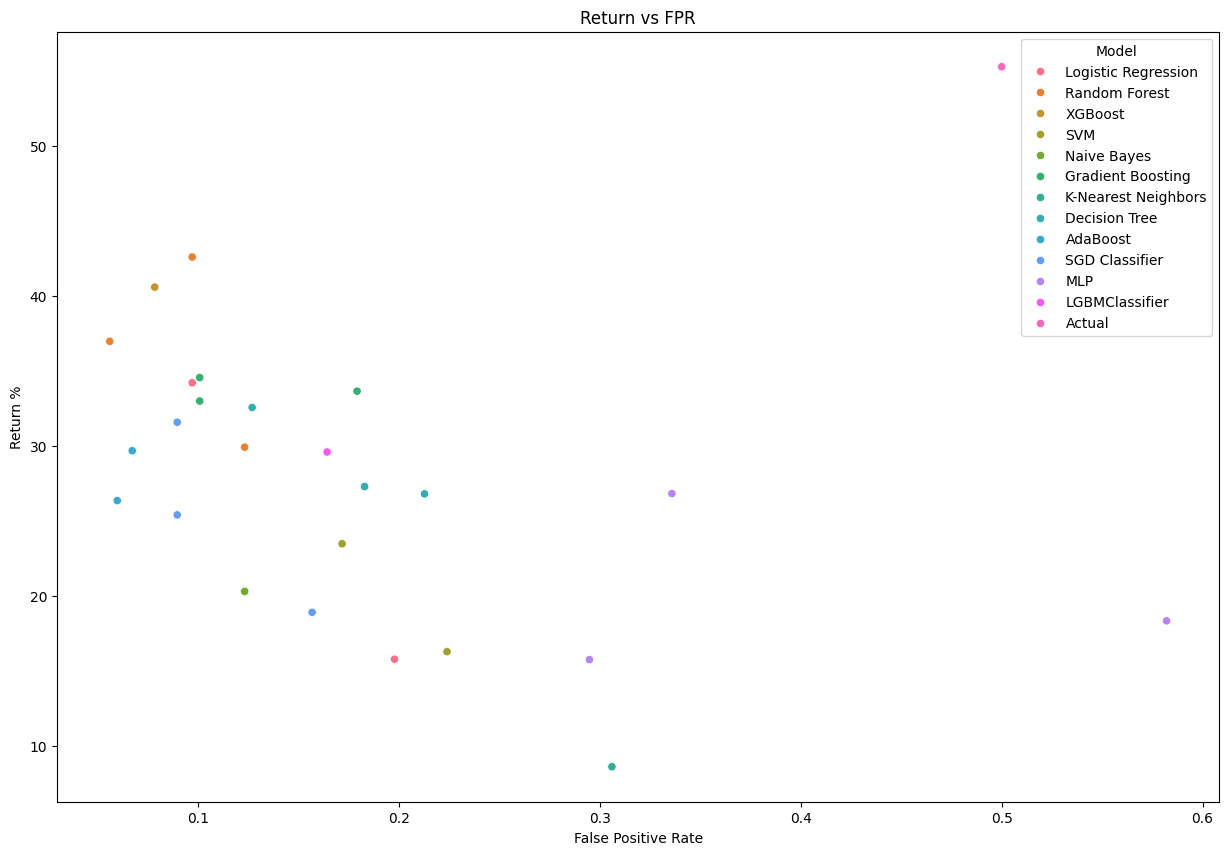

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='FPR', y='Return [%]_x', hue='Model')
plt.title('Return vs FPR')
plt.xlabel('False Positive Rate')
plt.ylabel('Return %')

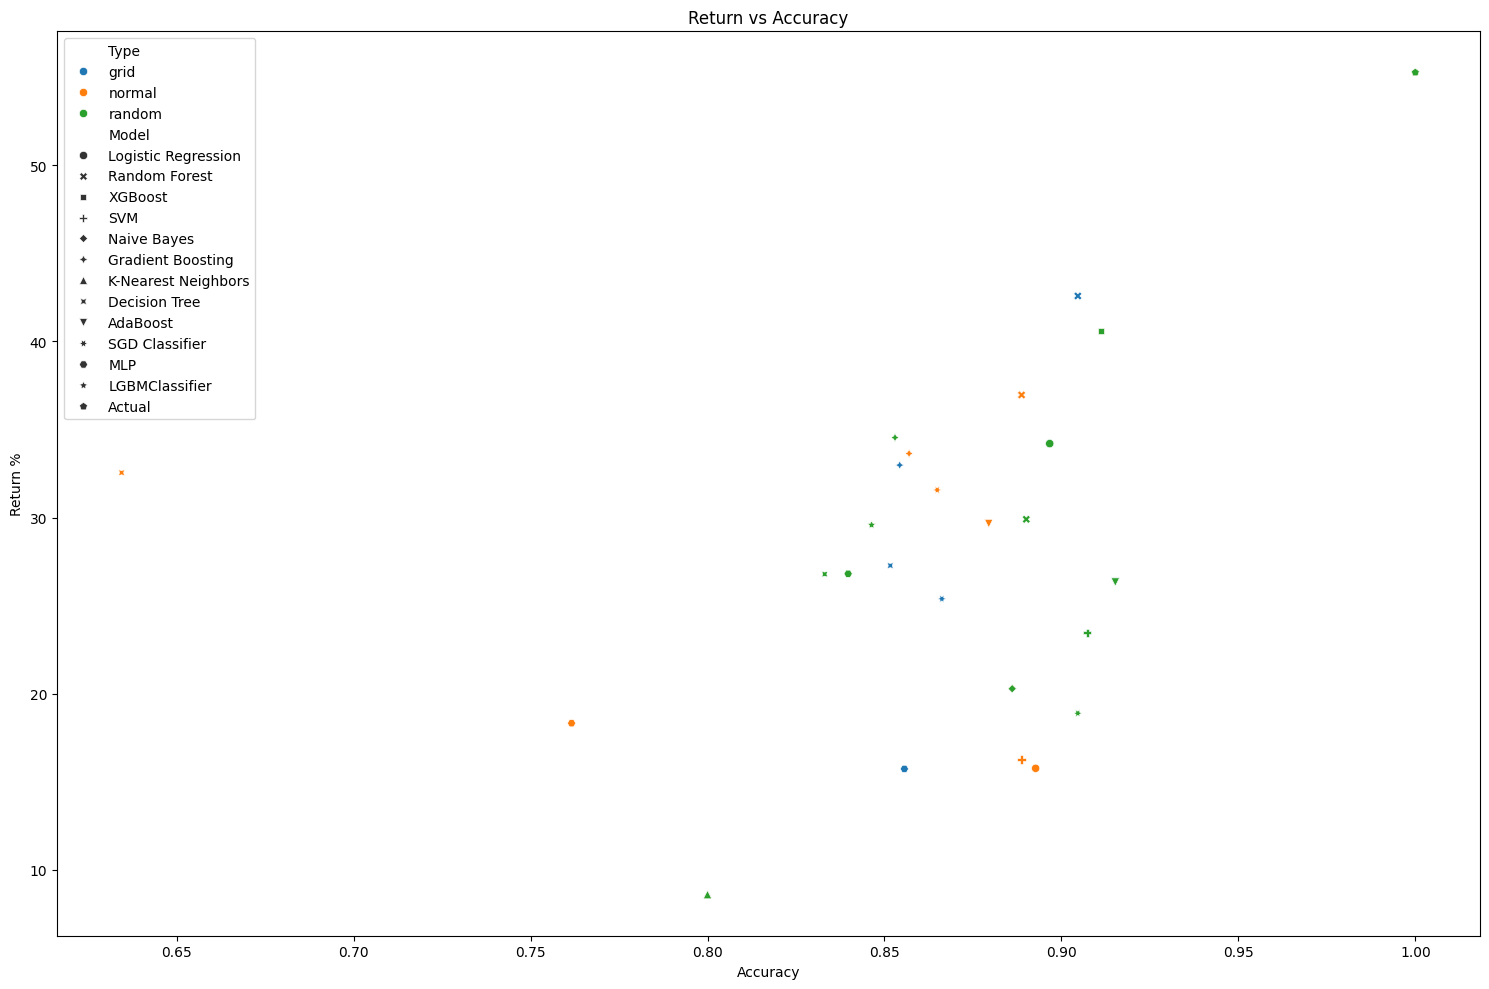

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='Accuracy_x', y='Return [%]_x', hue='Type', style='Model')
plt.title('Return vs Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Return %')

plt.tight_layout()
plt.show()


In [ ]:
data.sort_values('Return [%]_x',ascending = False)

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,TN,FP,FN,TP,Precision,TPR,FPR
38,SPY,Actual,1.000000,55.272000,36.59818,55.272000,random,1,1,1,1,0.500000,0.500000,0.500000
25,SPY,Actual,1.000000,55.272000,36.59818,55.272000,normal,1,1,1,1,0.500000,0.500000,0.500000
12,SPY,Actual,1.000000,55.272000,36.59818,55.272000,grid,1,1,1,1,0.500000,0.500000,0.500000
1,SPY,Random Forest,0.904636,42.579884,36.59818,41.372384,grid,242,26,46,441,0.944325,0.905544,0.097015
15,SPY,XGBoost,0.911258,40.574894,36.59818,40.576894,normal,247,21,46,441,0.954545,0.905544,0.078358
2,SPY,XGBoost,0.911258,40.574894,36.59818,40.576894,grid,247,21,46,441,0.954545,0.905544,0.078358
28,SPY,XGBoost,0.911258,40.574894,36.59818,40.576894,random,247,21,46,441,0.954545,0.905544,0.078358
14,SPY,Random Forest,0.888742,36.958004,36.59818,36.984402,normal,253,15,69,418,0.965358,0.858316,0.055970
31,SPY,Gradient Boosting,0.852980,34.539384,36.59818,36.091789,random,241,27,84,403,0.937209,0.827515,0.100746
0,SPY,Logistic Regression,0.896689,34.197395,36.59818,34.197395,grid,242,26,52,435,0.943601,0.893224,0.097015


In [ ]:
results = []

for ticker in df.Model.unique():
    log_model = df[df.Model == ticker]
    for t in df.Type.unique():
        norm_log = log_model[log_model.Type == t]
        for l in norm_log.lag.unique():
            data = norm_log[norm_log['lag'] == l]
            total_return = data['Return [%]_x'].sum()
            total_bh_return = data['Buy & Hold Return [%]_x'].sum()

            results.append({
                'Model': ticker,
                'Type': t,
                'lag': l,
                'Total Strategy Return [%]': total_return,
                'Total Buy & Hold Return [%]': total_bh_return
            })

# Convert list of dictionaries into DataFrame
summary_df = pd.DataFrame(results)
print(summary_df)


                   Model    Type  lag  Total Strategy Return [%]  \
0    Logistic Regression    grid    0                 808.980941   
1    Logistic Regression    grid   10                 806.111349   
2    Logistic Regression    grid   15                 826.822028   
3    Logistic Regression    grid   20                 840.675949   
4    Logistic Regression    grid   25                 800.643799   
..                   ...     ...  ...                        ...   
502               Actual  random   45                2137.606412   
503               Actual  random   50                2137.606412   
504               Actual  random   55                2077.840635   
505               Actual  random    5                2085.038914   
506               Actual  random   60                2071.299066   

     Total Buy & Hold Return [%]  
0                     969.430951  
1                     913.855285  
2                     948.224642  
3                     915.385676  
4       

In [ ]:
pd.set_option('display.max_rows',None)

In [ ]:
summary_df.sort_values('Total Strategy Return [%]',ascending = False)

,Model,Type,lag,Total Strategy Return [%],Total Buy & Hold Return [%]
481,Actual,normal,0,2172.412945,969.430951
494,Actual,random,0,2172.412945,969.430951
468,Actual,grid,0,2172.412945,969.430951
489,Actual,normal,45,2137.606412,1135.406901
488,Actual,normal,40,2137.606412,1025.845914
485,Actual,normal,25,2137.606412,999.096218
486,Actual,normal,30,2137.606412,1104.955599
498,Actual,random,25,2137.606412,999.096218
502,Actual,random,45,2137.606412,1135.406901
503,Actual,random,50,2137.606412,1041.505195


In [86]:
data = df[df['Model']!= 'Actual']

In [87]:
data.isnull().sum()

Ticker                0
Unnamed: 1            0
Model                 0
Accuracy_x            0
Confusion Matrix_x    0
                     ..
_strategy_y           0
_equity_curve_y       0
_trades_y             0
lag                   0
Type                  0
Length: 77, dtype: int64

In [88]:
data = data[['Ticker','Model', 'Accuracy_x', 'Confusion Matrix_x','Return [%]_x','Buy & Hold Return [%]_x','Return [%]_y', 'Type','lag']]


In [89]:
data = get_metrics(data)
data = data[data['lag'] != 0]
data = data[data['FP'] != 0]
data = data[data['FN'] != 0]
data = data[data['TP'] != 0]
data = data[data['TN'] != 0]

In [90]:
data.groupby('Model')['Return [%]_x'].sum()

Model
AdaBoost               22499.769592
Decision Tree          25599.924333
Gradient Boosting      24864.981102
K-Nearest Neighbors    19805.183554
LGBMClassifier         24555.548746
Logistic Regression    27842.074877
MLP                    23015.765666
Naive Bayes            21893.711004
Random Forest          24961.425983
SGD Classifier         22892.639593
SVM                    22512.075335
XGBoost                23399.776259
Name: Return [%]_x, dtype: float64

In [91]:
data.columns

Index(['Ticker', 'Model', 'Accuracy_x', 'Return [%]_x',
       'Buy & Hold Return [%]_x', 'Return [%]_y', 'Type', 'lag', 'TN', 'FP',
       'FN', 'TP', 'Precision', 'TPR', 'FPR'],
      dtype='object')

In [92]:
mean_d = data.groupby(['lag','Model','Ticker'])[['Return [%]_x', 'Buy & Hold Return [%]_x']].mean()


<Axes: xlabel='Ticker'>

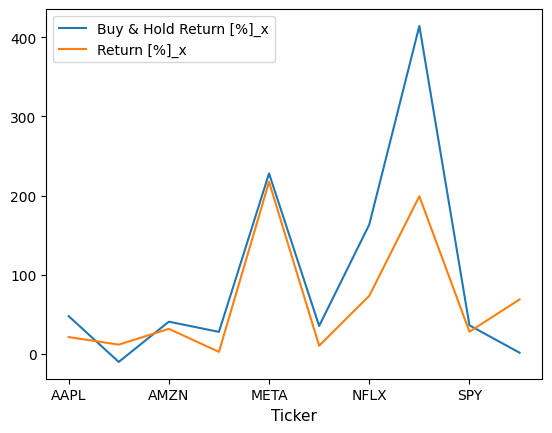

In [93]:
data.groupby('Ticker')[['Buy & Hold Return [%]_x', 'Return [%]_x']].mean().plot()


In [94]:
mean_d.T

lag                             5                                    \
Model                     AdaBoost                                    
Ticker                        AAPL        AMD       AMZN      GOOGL   
Return [%]_x             13.018514  10.668471  69.857445  -4.758321   
Buy & Hold Return [%]_x  45.815408 -14.664264  37.911444  26.986764   

lag                                                                     \
Model                                                                    
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             248.565334  10.895089  109.473959  187.203537   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

lag                                                                     \
Model                                         Decision Tree              
Ticker                         SPY       TSLA          AAPL        AMD   
Return [%]_x             27.443901  10.583596     29.234863   8.812625   
Buy & Hold Return [%]_x  36.598180   5.629584     45.815408 -14.664264   

lag                                                                   \
Model                                                                  
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             26.280150  -7.418851  196.376777   7.985572   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

lag                                                                     \
Model                                                                    
Ticker                         NFLX        NVDA        SPY        TSLA   
Return [%]_x              63.436027  188.523431  34.847616  218.544266   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180    5.629584   

lag                                                                         \
Model                   Gradient Boosting                                    
Ticker                               AAPL        AMD       AMZN      GOOGL   
Return [%]_x                    26.498594   6.507585  14.395397   4.968793   
Buy & Hold Return [%]_x         45.815408 -14.664264  37.911444  26.986764   

lag                                                                     \
Model                                                                    
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             183.190618  19.733325   74.865710  199.989063   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

lag                                                                           \
Model                                         K-Nearest Neighbors              
Ticker                         SPY       TSLA                AAPL        AMD   
Return [%]_x             32.639117  81.519377           13.085766 -28.594215   
Buy & Hold Return [%]_x  36.598180   5.629584           45.815408 -14.664264   

lag                                                                   \
Model                                                                  
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             45.124194  -3.030506  166.974319  24.405314   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

lag                                                                    \
Model                                                                   
Ticker                         NFLX        NVDA        SPY       TSLA   
Return [%]_x              65.116688  120.699709   8.586575  37.779400   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180   5.629584   

lag                                                                      \
Model                   LGBMClassifier                                    
Ticker                            AAPL        AMD       AMZN      GOOGL   
Return [%]_x                 17.614486  16.804800  38.8

In [95]:
pd.set_option('display.max_columns',None)

In [96]:
mean_d.T[0]

KeyError: 0

In [97]:
mean_d.T[5]

Model                     AdaBoost                                   \
Ticker                        AAPL        AMD       AMZN      GOOGL   
Return [%]_x             13.018514  10.668471  69.857445  -4.758321   
Buy & Hold Return [%]_x  45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             248.565334  10.895089  109.473959  187.203537   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                         Decision Tree             \
Ticker                         SPY       TSLA          AAPL        AMD   
Return [%]_x             27.443901  10.583596     29.234863   8.812625   
Buy & Hold Return [%]_x  36.598180   5.629584     45.815408 -14.664264   

Model                                                                 \
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             26.280150  -7.418851  196.376777   7.985572   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

Model                                                                   \
Ticker                         NFLX        NVDA        SPY        TSLA   
Return [%]_x              63.436027  188.523431  34.847616  218.544266   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180    5.629584   

Model                   Gradient Boosting                                   \
Ticker                               AAPL        AMD       AMZN      GOOGL   
Return [%]_x                    26.498594   6.507585  14.395397   4.968793   
Buy & Hold Return [%]_x         45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             183.190618  19.733325   74.865710  199.989063   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                         K-Nearest Neighbors             \
Ticker                         SPY       TSLA                AAPL        AMD   
Return [%]_x             32.639117  81.519377           13.085766 -28.594215   
Buy & Hold Return [%]_x  36.598180   5.629584           45.815408 -14.664264   

Model                                                                 \
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             45.124194  -3.030506  166.974319  24.405314   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

Model                                                                  \
Ticker                         NFLX        NVDA        SPY       TSLA   
Return [%]_x              65.116688  120.699709   8.586575  37.779400   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180   5.629584   

Model                   LGBMClassifier                                   \
Ticker                            AAPL        AMD       AMZN      GOOGL   
Return [%]_x                 17.614486  16.804800  38.858204  20.491375   
Buy & Hold Return [%]_x      45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             220.853323  13.586506   30.697218  220.937196   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                          Logistic Regression             \
Ticker                         SPY        TSLA                AAPL        AMD   
Return [%]_x             29.576703  143.920407           23.417716  15.822530   
Buy & Hold Return [%]_x  36.598180    5.629584           45.815408 -14.664264   

Model                                                                 \
Ticker                     

In [98]:
mean_d.T[20]['AdaBoost'].T

,Return [%]_x,Buy & Hold Return [%]_x
Ticker,,
AAPL,10.223650,42.471185
AMD,12.098836,-15.869121
AMZN,78.321563,37.281530
GOOGL,-5.678124,25.212245
META,226.932168,216.294262
MSFT,14.225755,30.760517
NFLX,86.417329,153.419470
NVDA,182.793261,396.077642
SPY,26.990465,33.606606


In [99]:
data[(data['lag'] == 20) & (data['Model'] == 'AdaBoost')]

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
1178,AAPL,AdaBoost,0.888149,13.406920,42.471185,11.695714,grid,20,314,43,41,353,0.891414,0.895939,0.120448
1191,AMD,AdaBoost,0.876165,4.600998,-15.869121,13.158005,grid,20,372,51,42,286,0.848665,0.871951,0.120567
1204,AMZN,AdaBoost,0.884154,86.098151,37.281530,75.978870,grid,20,265,20,67,399,0.952267,0.856223,0.070175
1217,GOOGL,AdaBoost,0.886818,-3.578182,25.212245,-3.936395,grid,20,285,41,44,381,0.902844,0.896471,0.125767
1230,META,AdaBoost,0.818908,223.203386,216.294262,216.152772,grid,20,196,52,84,419,0.889597,0.833002,0.209677
1243,MSFT,AdaBoost,0.897470,18.337996,30.760517,17.815896,grid,20,315,20,57,359,0.947230,0.862981,0.059701
1256,NFLX,AdaBoost,0.860186,78.937291,153.419470,74.497789,grid,20,202,48,57,444,0.902439,0.886228,0.192000
1269,NVDA,AdaBoost,0.893475,166.077617,396.077642,138.722356,grid,20,257,45,35,414,0.901961,0.922049,0.149007
1282,SPY,AdaBoost,0.912117,26.837101,33.606606,26.503807,grid,20,248,16,50,437,0.964680,0.897331,0.060606
1295,TSLA,AdaBoost,0.864181,22.985455,-3.868660,8.383537,grid,20,368,58,44,281,0.828909,0.864615,0.136150


In [100]:
# Adjust layout with more space between subplots
plt.tight_layout(h_pad=2, w_pad=5)
plt.show()


<Figure size 640x480 with 0 Axes>

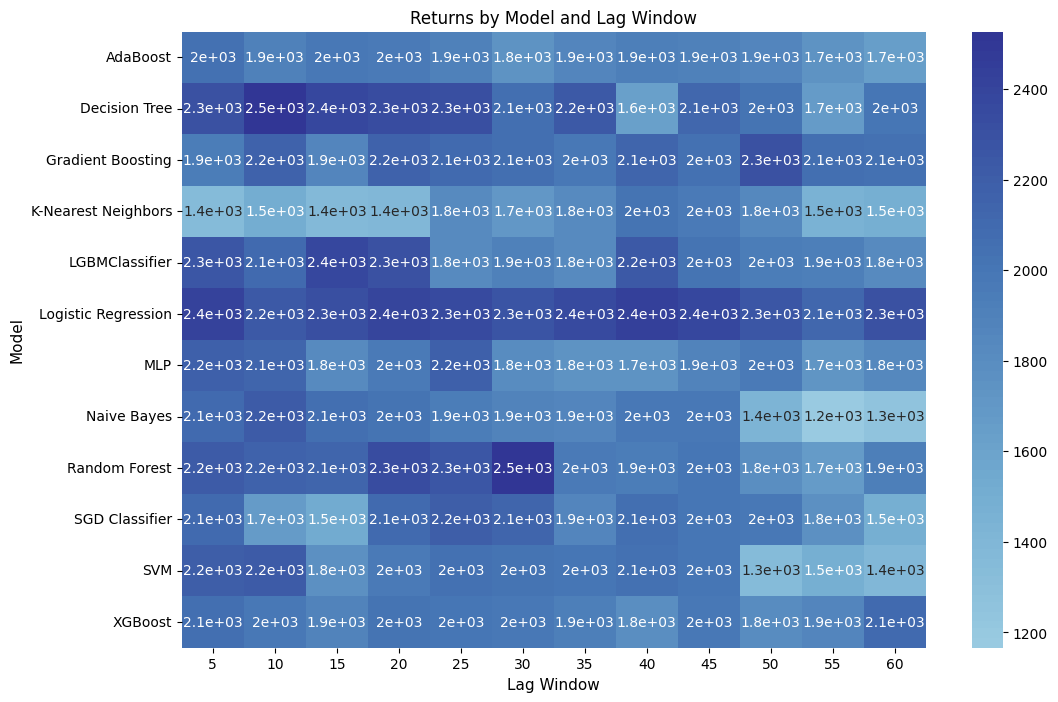

In [101]:
# Alternative heatmap visualization
plt.figure(figsize=(12, 8))
pivot_data = data.pivot_table(
    values='Return [%]_x', 
    index='Model',
    columns='lag',
    aggfunc='sum'
)
sns.heatmap(pivot_data, annot=True, cmap='RdYlBu', center=0)
plt.title('Returns by Model and Lag Window')
plt.xlabel('Lag Window')
plt.ylabel('Model')
plt.show()


In [102]:
best_models = data.loc[data.groupby('Ticker')['Return [%]_x'].idxmax()]

In [103]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
2735,AAPL,Gradient Boosting,0.763758,59.149417,49.697197,59.204817,grid,40,206,145,31,363,0.714567,0.921320,0.413105
933,AMD,MLP,0.844415,108.920508,-12.580163,71.901396,normal,15,369,54,63,266,0.831250,0.808511,0.127660
1336,AMZN,MLP,0.878828,109.918000,37.281530,92.343584,normal,20,225,60,31,435,0.878788,0.933476,0.210526
439,GOOGL,MLP,0.885942,32.684564,25.316542,22.605272,grid,10,262,67,19,406,0.858351,0.955294,0.203647
4602,META,Logistic Regression,0.814570,374.448071,217.071277,368.180879,random,5,174,78,62,441,0.849711,0.876740,0.309524
846,MSFT,Random Forest,0.678191,57.107556,33.083568,57.642849,grid,15,334,2,240,176,0.988764,0.423077,0.005952
2812,NFLX,Naive Bayes,0.708725,136.442228,169.941429,105.512831,grid,40,176,70,147,352,0.834123,0.705411,0.284553
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
1021,SPY,Decision Tree,0.836436,59.957582,36.064462,56.876181,normal,15,229,36,87,400,0.917431,0.821355,0.135849
4414,TSLA,Decision Tree,0.896689,263.155551,5.629584,198.593252,grid,5,385,45,33,292,0.866469,0.898462,0.104651


In [113]:
best_models = data.loc[data.groupby('Ticker')['FPR'].idxmin()]

In [114]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
1049,AAPL,SGD Classifier,0.871011,35.931200,45.404416,40.199998,random,15,351,7,90,304,0.977492,0.771574,0.019553
3137,AMD,Naive Bayes,0.749664,23.875701,-2.679705,32.662705,grid,45,414,2,184,143,0.986207,0.437309,0.004808
810,AMZN,Naive Bayes,0.743351,27.376652,38.108539,12.660349,grid,15,282,3,190,277,0.989286,0.593148,0.010526
4728,GOOGL,SGD Classifier,0.518268,-10.115698,23.782830,-9.942897,grid,60,312,2,354,71,0.972603,0.167059,0.006369
3441,META,SGD Classifier,0.780619,186.732484,252.697837,179.336791,random,45,231,9,154,349,0.974860,0.693837,0.037500
1764,MSFT,SGD Classifier,0.798398,2.099294,35.420554,-0.486411,normal,25,332,1,150,266,0.996255,0.639423,0.003003
598,NFLX,Logistic Regression,0.867374,70.851010,146.435526,80.824915,normal,10,231,19,81,423,0.957014,0.839286,0.076000
2700,NVDA,SGD Classifier,0.663539,93.441974,422.073528,87.236830,random,35,296,1,250,199,0.995000,0.443207,0.003367
3618,SPY,Naive Bayes,0.849057,23.400606,37.280890,23.364706,grid,50,247,8,104,383,0.979540,0.786448,0.031373
3896,TSLA,SGD Classifier,0.799191,202.202578,5.482055,190.800500,random,50,409,8,141,184,0.958333,0.566154,0.019185


In [104]:
data.loc[data.groupby('Model')['Return [%]_y'].idxmax()]

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
4480,META,AdaBoost,0.846358,257.253139,217.071277,252.415138,normal,5,196,56,60,443,0.887776,0.880716,0.222222
3829,META,Decision Tree,0.809973,313.572507,242.779771,330.207017,random,50,177,62,79,424,0.872428,0.842942,0.259414
486,NVDA,Gradient Boosting,0.881963,285.237794,397.371377,364.368615,grid,10,267,38,51,398,0.912844,0.886414,0.124590
3178,META,K-Nearest Neighbors,0.788694,239.224412,252.697837,251.144441,grid,45,191,49,108,395,0.889640,0.785288,0.204167
1233,META,LGBMClassifier,0.833555,280.981146,216.294262,275.555541,grid,20,190,58,67,436,0.882591,0.866799,0.233871
2821,NVDA,Logistic Regression,0.887248,309.205761,430.276267,394.380499,grid,40,261,35,49,400,0.919540,0.890869,0.118243
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
3631,TSLA,Naive Bayes,0.811321,131.732559,5.482055,233.333673,grid,50,319,98,42,283,0.742782,0.870769,0.235012
2172,NVDA,Random Forest,0.822193,297.271700,462.710779,326.574506,normal,30,293,6,127,322,0.981707,0.717149,0.020067
620,NVDA,SGD Classifier,0.824934,340.499382,397.371377,364.070114,normal,10,300,5,127,322,0.984709,0.717149,0.016393


In [105]:
best_models.corr(numeric_only=True)

,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,lag,TN,FP,FN,TP,Precision,TPR,FPR
Accuracy_x,1.000000,0.246058,-0.074517,0.193736,-0.578048,0.256258,-0.019257,-0.811467,0.465440,-0.036893,0.777425,-0.106831
Return [%]_x,0.246058,1.000000,0.777662,0.988352,-0.514636,0.012041,-0.206162,-0.079903,0.175231,0.216743,0.108909,-0.120103
Buy & Hold Return [%]_x,-0.074517,0.777662,1.000000,0.832491,-0.172138,-0.311653,-0.186644,0.170784,0.244843,0.278012,-0.086131,-0.043200
Return [%]_y,0.193736,0.988352,0.832491,1.000000,-0.502623,-0.067732,-0.198605,-0.040787,0.212952,0.244115,0.078418,-0.098872
lag,-0.578048,-0.514636,-0.172138,-0.502623,1.000000,-0.487936,0.606635,0.117108,0.023188,-0.593268,-0.066221,0.617633
TN,0.256258,0.012041,-0.311653,-0.067732,-0.487936,1.000000,-0.527101,0.097418,-0.735893,0.348422,-0.240333,-0.743330
FP,-0.019257,-0.206162,-0.186644,-0.198605,0.606635,-0.527101,1.000000,-0.568616,0.454884,-0.961817,0.591687,0.949772
FN,-0.811467,-0.079903,0.170784,-0.040787,0.117108,0.097418,-0.568616,1.000000,-0.648824,0.593287,-0.985818,-0.467190
TP,0.465440,0.175231,0.244843,0.212952,0.023188,-0.735893,0.454884,-0.648824,1.000000,-0.327975,0.756523,0.595428
Precision,-0.036893,0.216743,0.278012,0.244115,-0.593268,0.348422,-0.961817,0.593287,-0.327975,1.000000,-0.592691,-0.874418


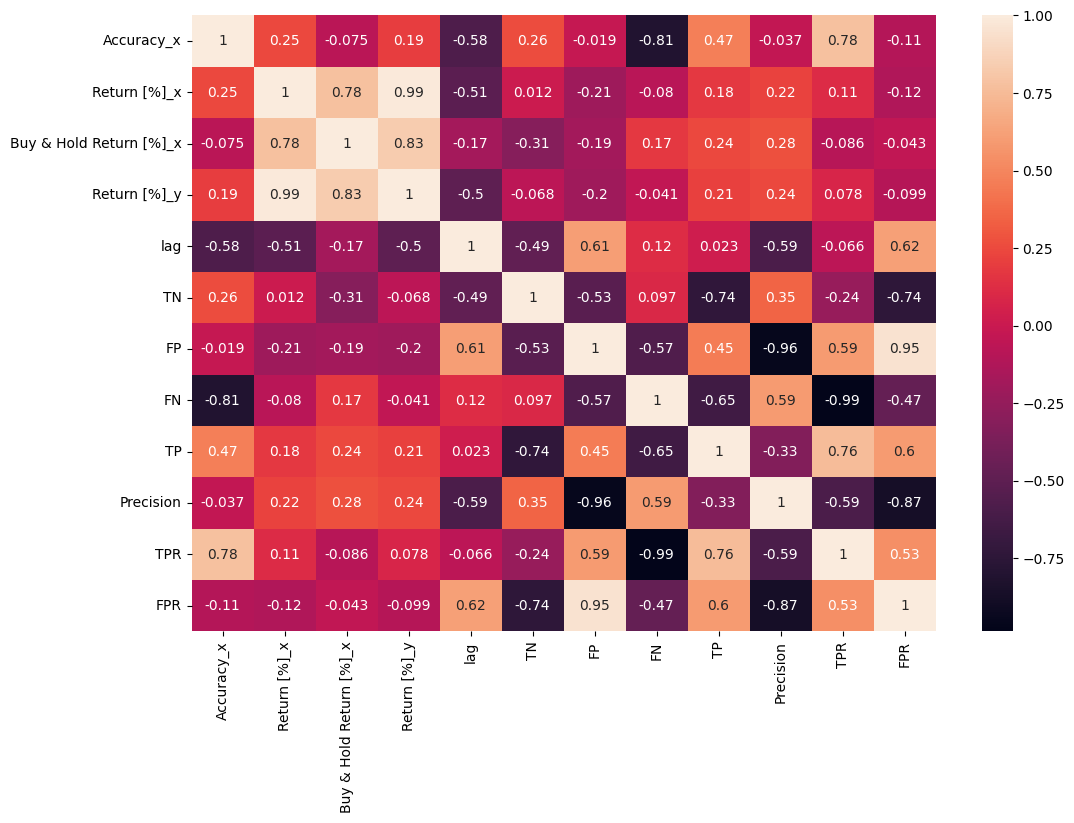

In [106]:
plt.figure(figsize=(12, 8))
sns.heatmap(best_models.corr(numeric_only=True), annot=True)
plt.show()

In [107]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
2735,AAPL,Gradient Boosting,0.763758,59.149417,49.697197,59.204817,grid,40,206,145,31,363,0.714567,0.921320,0.413105
933,AMD,MLP,0.844415,108.920508,-12.580163,71.901396,normal,15,369,54,63,266,0.831250,0.808511,0.127660
1336,AMZN,MLP,0.878828,109.918000,37.281530,92.343584,normal,20,225,60,31,435,0.878788,0.933476,0.210526
439,GOOGL,MLP,0.885942,32.684564,25.316542,22.605272,grid,10,262,67,19,406,0.858351,0.955294,0.203647
4602,META,Logistic Regression,0.814570,374.448071,217.071277,368.180879,random,5,174,78,62,441,0.849711,0.876740,0.309524
846,MSFT,Random Forest,0.678191,57.107556,33.083568,57.642849,grid,15,334,2,240,176,0.988764,0.423077,0.005952
2812,NFLX,Naive Bayes,0.708725,136.442228,169.941429,105.512831,grid,40,176,70,147,352,0.834123,0.705411,0.284553
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
1021,SPY,Decision Tree,0.836436,59.957582,36.064462,56.876181,normal,15,229,36,87,400,0.917431,0.821355,0.135849
4414,TSLA,Decision Tree,0.896689,263.155551,5.629584,198.593252,grid,5,385,45,33,292,0.866469,0.898462,0.104651


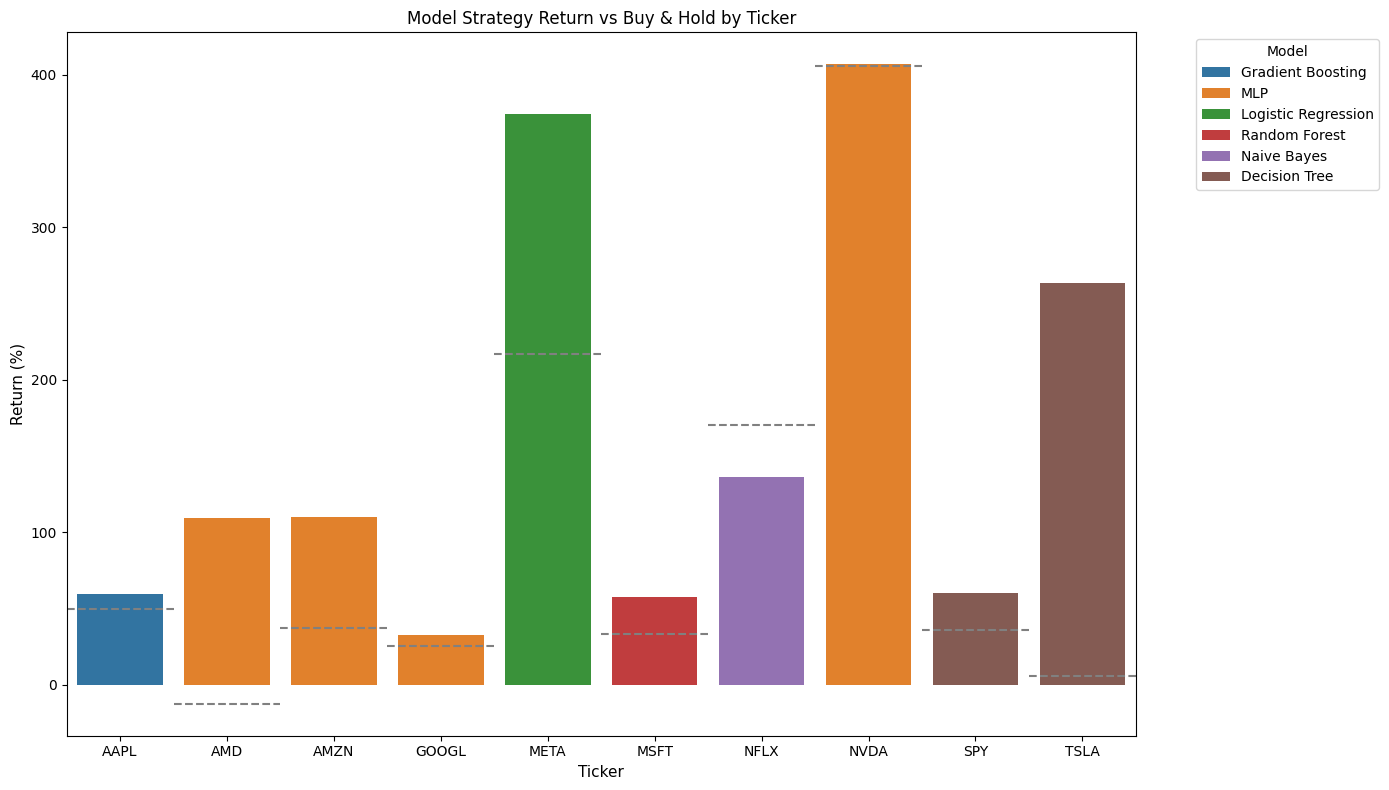

In [108]:
plt.figure(figsize=(14, 8))

# Plot model strategy returns
sns.barplot(data=best_models, x='Ticker', y='Return [%]_x', hue='Model')

# Plot buy & hold returns as a line for each ticker
for i, ticker in enumerate(best_models['Ticker']):
    bh_return = best_models.loc[best_models['Ticker'] == ticker, 'Buy & Hold Return [%]_x'].values[0]
    plt.axhline(y=bh_return, linestyle='--', color='gray', xmin=i/len(best_models), xmax=(i+1)/len(best_models))

plt.title('Model Strategy Return vs Buy & Hold by Ticker')
plt.ylabel('Return (%)')
plt.xlabel('Ticker')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [109]:
best_models['Return [%]_x'].sum()

np.float64(1608.5519006347658)

In [110]:
best_models['Return [%]_y'].sum()

np.float64(1434.07038980484)